In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# Read the data
X_full = pd.read_csv('C:/Users/yasha/missing_values_train.csv', index_col='Id')
X_test_full = pd.read_csv('C:/Users/yasha/missing_values_test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [2]:
print(X_train.shape)
print(y_train.shape)

(1168, 36)
(1168,)


In [3]:
print(y_valid.shape)
print(X_valid.shape)

(292,)
(292, 36)


# Step 1: Preliminary investigation

In [4]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1168, 36)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [5]:
# How many rows are in the training data?
num_rows = 1168

# How many columns in the training data have missing values?
num_cols_with_missing = 3

# How many missing entries are contained in all of the training data?
tot_missing = 212+6+58

To compare different approaches to dealing with missing values, you'll use the same `score_dataset()` function from the tutorial.  This function reports the mean absolute error (MAE) from a random forest model.

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Step 2: Drop columns with missing values

In this step, you'll preprocess the data in `X_train` and `X_valid` to remove columns with missing values.  Set the preprocessed DataFrames to `reduced_X_train` and `reduced_X_valid`, respectively.  

In [7]:
# get names of columns with missing values
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

In [8]:
reduced_X_valid.shape

(292, 33)

In [9]:
print("MAE (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE (Drop columns with missing values):
17837.82570776256


# Step 3: Imputation

Use the next code cell to impute missing values with the mean value along each column.  Set the preprocessed DataFrames to `imputed_X_train` and `imputed_X_valid`.  Make sure that the column names match those in `X_train` and `X_valid`.

In [10]:
from sklearn.impute import SimpleImputer

# imputation
my_impute = SimpleImputer()
# preprocess train and test data
imputed_X_train = pd.DataFrame(my_impute.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_impute.transform(X_valid))

# imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

In [11]:
imputed_X_valid.shape

(292, 36)

In [12]:
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Imputation):
18062.894611872147


# Step 4: Generate test predictions

Set the preprocessed DataFrames to `final_X_train` and `final_X_valid`.  **You can use any approach of your choosing here!**  in order for this step to be marked as correct, you need only ensure:
- the preprocessed DataFrames have the same number of columns,
- the preprocessed DataFrames have no missing values, 
- `final_X_train` and `y_train` have the same number of rows, and
- `final_X_valid` and `y_valid` have the same number of rows.

In [13]:
# Preprocessed training and validation features
final_X_train = imputed_X_train
final_X_valid = imputed_X_valid

In [14]:
final_X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20.0,90.000000,11694.0,9.0,5.0,2007.0,2007.0,452.0,48.0,0.0,...,774.0,0.0,108.0,0.0,0.0,260.0,0.0,0.0,7.0,2007.0
1,20.0,60.000000,6600.0,5.0,5.0,1962.0,1962.0,0.0,0.0,0.0,...,308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2009.0
2,30.0,80.000000,13360.0,5.0,7.0,1921.0,2006.0,0.0,713.0,0.0,...,432.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,8.0,2009.0
3,20.0,69.614017,13265.0,8.0,5.0,2002.0,2002.0,148.0,1218.0,0.0,...,857.0,150.0,59.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0
4,20.0,118.000000,13704.0,7.0,5.0,2001.0,2002.0,150.0,0.0,0.0,...,843.0,468.0,81.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0


In [15]:
final_X_valid.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20.0,69.614017,32668.0,6.0,3.0,1957.0,1975.0,103.481067,1219.0,0.0,...,484.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,3.0,2007.0
1,50.0,79.000000,9490.0,6.0,7.0,1941.0,1950.0,0.000000,403.0,165.0,...,240.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,8.0,2006.0
2,50.0,69.614017,7015.0,5.0,4.0,1950.0,1950.0,161.000000,185.0,0.0,...,352.0,0.0,0.0,248.0,0.0,0.0,0.0,0.0,7.0,2009.0
3,60.0,83.000000,10005.0,7.0,5.0,1977.0,1977.0,299.000000,392.0,0.0,...,505.0,288.0,117.0,0.0,0.0,0.0,0.0,0.0,3.0,2008.0
4,160.0,21.000000,1680.0,6.0,5.0,1971.0,1971.0,381.000000,0.0,0.0,...,264.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0


(*Note that we don't use the `score_dataset()` function above, because we will soon use the trained model to generate test predictions!*)

In [16]:
# Define and fit model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model = model.fit(final_X_train, y_train)

# Get validation predictions and MAE
preds_valid = model.predict(final_X_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))

MAE (Your approach):
18062.894611872147


In [17]:
# preprocess test data
final_X_test = pd.DataFrame(my_impute.transform(X_test))

# get test predictions
preds_test = model.predict(final_X_test)

In [18]:
preds_test.shape

(1459,)

In [19]:
final_X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,...,730.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,...,312.0,393.0,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,...,482.0,212.0,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,0.0,...,470.0,360.0,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,0.0,...,506.0,0.0,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0


In [20]:
print(final_X_valid.shape)
print(final_X_train.shape)

(292, 36)
(1168, 36)


In [21]:
# get validation predictions
preds_valid = model.predict(final_X_valid)

In [22]:
print(y_valid.shape)
print(y_train.shape)

(292,)
(1168,)


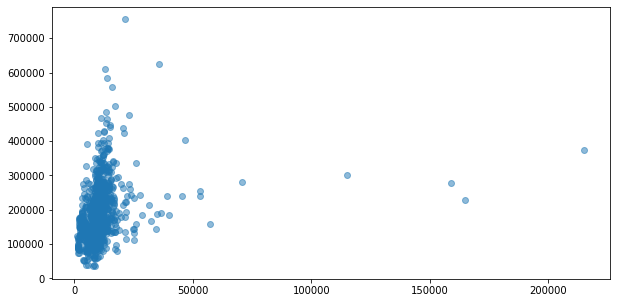

In [23]:
plt.figure(figsize=(10,5))
plt.scatter(final_X_train.LotArea, y_train, alpha=0.5)

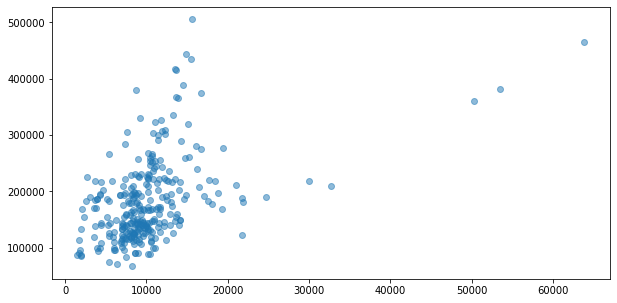

In [24]:
plt.figure(figsize=(10,5))
plt.scatter(final_X_valid.LotArea,preds_valid, alpha=0.5)

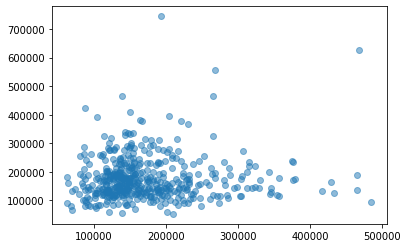

In [25]:
plt.scatter(preds_test[1000:],y[1001:],alpha=0.5)

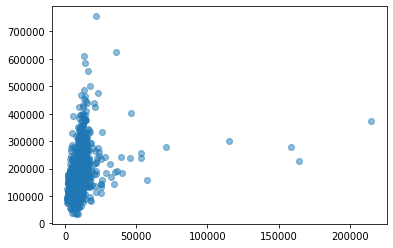

In [26]:
plt.scatter(final_X_train.LotArea, y_train, alpha=0.5)

In [27]:
print(model.score(final_X_train,y_train))

0.9795015907223191


In [28]:
print(model.score(final_X_valid,y_valid))

0.8297327676551016


In [29]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds_valid))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds_valid))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds_valid)))

Mean Absolute Error: 18062.894611872147
Mean Squared Error: 1175839960.3600028
Root Mean Squared Error: 34290.522894234244
